<a href="https://colab.research.google.com/github/dawitfamanu/dawitfamanu.github.io/blob/main/LSTM_V3_dawit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# set the directory path for the two classes
n_data_dir = "/content/drive/MyDrive/final_dataset/n_data"
d_data_dir = "/content/drive/MyDrive/final_dataset/d_data"

# read all csv files from the n_data directory and remove outliers
min = 200 #the minimum number of rows in the entire dataset
n_data_files = os.listdir(n_data_dir)
n_data = pd.DataFrame()
outlier_n_data = []
for file in n_data_files:
    if file.endswith(".csv"):
      file_path = os.path.join(n_data_dir, file)
      df = pd.read_csv(file_path)
      if df.shape[0] <min:
        continue

      max_t = df.iloc[:, 2]
      for i in range(len(max_t)): # find outliers in max_temp (>50 degrees)
        if max_t[i] > 50:
          outlier_n_data.append(file_path)
      
      if file_path in outlier_n_data: 
        continue
      else: # add the files only if they are not an outlier
        n_data = pd.concat([n_data, df.iloc[:min, :]])

outlier_n_data = set(outlier_n_data)

# read all csv files from the d_data directory
d_data_files = os.listdir(d_data_dir)
d_data = pd.DataFrame()
for file in d_data_files:
    if file.endswith(".csv"):
      file_path = os.path.join(d_data_dir, file)
      df = pd.read_csv(file_path)
      if df.shape[0] <min:
        continue
      
      d_data = pd.concat([d_data, df.iloc[:min, :]])

In [ ]:
#Normal = 0, #Disease = 1
n_data["Status"] = 0
d_data["Status"] = 1

In [ ]:
combined_data = pd.concat([n_data, d_data], axis = 0)

In [ ]:
combined_data.drop(["time" ," CO2_avg", " CO2_max", " CO2_min"], axis = 1, inplace=True)

In [ ]:
combined_data.shape

(1777200, 10)

In [19]:
combined_data

NameError: ignored

In [ ]:
dfs = np.array_split(combined_data, len(combined_data)/ 200)

# save each chunk to a separate csv file
for i, df_chunk in enumerate(dfs):
    df_chunk.to_csv(f'/content/drive/MyDrive/output/output_{i+1}.csv', index=False)

In [ ]:
len(dfs)

8886

In [4]:
data_dir = "/content/drive/MyDrive/output"

In [5]:
def read_csv_files(folder_path): #reads csv files and returns puts all the data in 1 list
    data_list = []

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        data_list.append(df.values[:, :]) 
    
    return list(data_list)

#splits features and labels into two different arrays
def get_features_and_labels(data_list):
  features_X = []
  labels_y = []
  for data in data_list:
    labels_y.append(data[:, -1]) #store the label of data 
    features_X.append(data[:, :-1]) #store the features of data exculding label
  
  return np.array(features_X), np.array(labels_y)


def create_sequences_from_list(features_list, labels_list, seq_length):#slightly modified from Jungi's function
    feat_sequences = []
    labels_seq = []
    for data in features_list: # create seq for features list
      feat_sequences.append(data[:seq_length, :])
    for data in labels_list: # create seq for labels list
      labels_seq.append(data[:1][0]) 

    return np.array(feat_sequences), np.array(labels_seq) #return feature and label sequences as pandas array


all_data_list = read_csv_files(data_dir)

In [10]:
print("Total # of plants: ", len(all_data_list))
print("Recordings per plant: ", len(all_data_list[0]))

Total # of plants:  8886
Recordings per plant:  200


array([22.2, 23.1, 21. , 75.2, 80.4, 72.2, 17.6, 18.4, 16.6,  0. ])

In [11]:
#shuffle all_data_list
random.shuffle(all_data_list)

In [12]:
#first, store labels and features separately
features_X, labels_y = get_features_and_labels(all_data_list)

In [ ]:
features_X

In [13]:
features_X.shape

(8886, 200, 9)

In [14]:
labels_y.shape

(8886, 200)

In [29]:
#train test split 
train_features_X, test_features_X, train_labels_y, test_labels_y = train_test_split(features_X, labels_y, test_size=0.2, random_state=20)

In [30]:
#Create sequences
seq_length = 200

#make sequences of length 200 for X_train, X_test, y_train, y_test
X_train, y_train = create_sequences_from_list(train_features_X, train_labels_y, seq_length)
X_test, y_test = create_sequences_from_list(test_features_X, test_labels_y, seq_length)

In [ ]:
X_train.shape

(7108, 200, 9)

In [33]:
y_train.shape

(7108,)

In [34]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(10))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
178/178 [==============================] - 35s 174ms/step - loss: 0.6894 - accuracy: 0.5375 - val_loss: 0.6672 - val_accuracy: 0.8896
Epoch 2/10
178/178 [==============================] - 44s 250ms/step - loss: 0.6286 - accuracy: 0.6864 - val_loss: 0.5558 - val_accuracy: 0.9135
Epoch 3/10
178/178 [==============================] - 35s 196ms/step - loss: 0.5273 - accuracy: 0.8519 - val_loss: 0.4265 - val_accuracy: 0.9297
Epoch 4/10
178/178 [==============================] - 40s 225ms/step - loss: 0.3955 - accuracy: 0.9370 - val_loss: 0.2958 - val_accuracy: 0.9810
Epoch 5/10
178/178 [==============================] - 31s 170ms/step - loss: 0.3062 - accuracy: 0.9567 - val_loss: 0.2282 - val_accuracy: 0.9810
Epoch 6/10
178/178 [==============================] - 38s 215ms/step - loss: 0.2574 - accuracy: 0.9666 - val_loss: 0.2358 - val_accuracy: 0.9346
Epoch 7/10
178/178 [==============================] - 37s 209ms/step - loss: 0.2288 - accuracy: 0.9705 - val_loss: 0.1756 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/LSTM_model_v3.h5')

In [ ]:
features_X.shape

(8886, 200, 9)

[0.7006781697273254, 0.69779372215271, 0.6973297595977783, 0.6934391260147095, 0.6874143481254578, 0.6478405594825745, 0.5260475873947144, 0.412683367729187, 0.31604817509651184, 0.2467910349369049]
[0.6930176019668579, 0.6920228004455566, 0.6910223364830017, 0.6872806549072266, 0.6726872324943542, 0.5768558979034424, 0.44182345271110535, 0.32548362016677856, 0.2467072606086731, 0.1916394829750061]


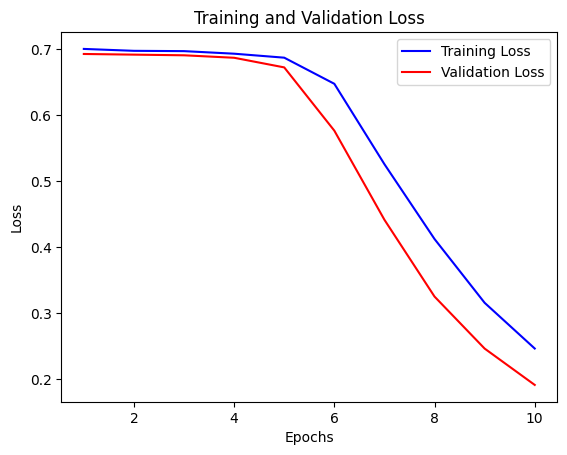

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the training history from the 'history' object returned by model.fit()
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

print(training_loss) 
print(validation_loss)

# Plot the training and validation loss
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, color='blue', label='Training Loss')
plt.plot(epochs, validation_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[0.5035173892974854, 0.5131902694702148, 0.4996482729911804, 0.5121350884437561, 0.5392191410064697, 0.6598663330078125, 0.8279985785484314, 0.8879704475402832, 0.9294759035110474, 0.952690839767456]
[0.5168776512145996, 0.5168776512145996, 0.5168776512145996, 0.4697608947753906, 0.7046413421630859, 0.8157524466514587, 0.8544303774833679, 0.9282700419425964, 0.9367088675498962, 0.9697608947753906]


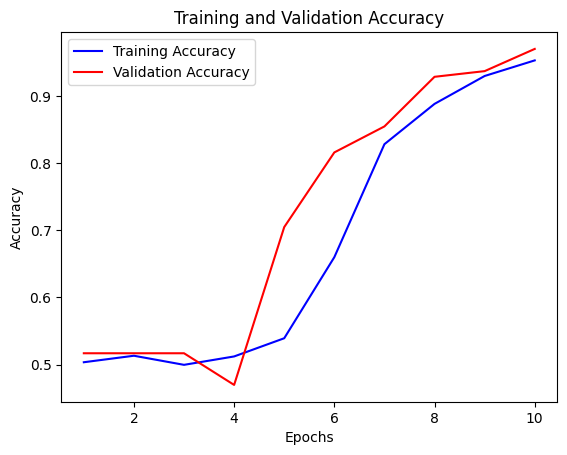

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the training history from the 'history' object returned by model.fit()
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print(training_accuracy) 
print(validation_accuracy)
# Plot the training and validation accuracy
epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, color='blue', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, color='red', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

56/56 [==============================] - 3s 30ms/step


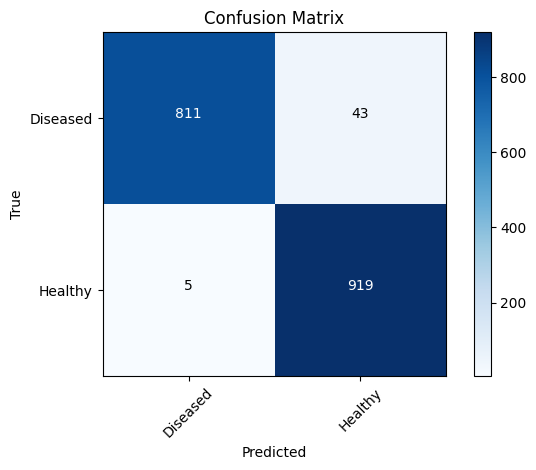

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Diseased', 'Healthy']

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
plt.show()

In [ ]:
from keras.models import load_model

filepath = "/content/drive/MyDrive/final_dataset/n_data/n_770079.csv"

df = pd.read_csv(filepath)

row_count = len(df)
min = 200

model = load_model('/content/drive/MyDrive/LSTM_model_v3.h5')

#Check if the input csv has enough number of recordings. We need at least 200 recordings

if(row_count >= min):
    test = df.iloc[:min, 1:10].values
    test = test.reshape((1, 200, 9))
    prediction = model.predict(test)
    if(prediction <= 0.5):
        condition = "Healthy"
        prediction = 1-prediction
    else:
        condition = "Unhealthy"
    print(f"There is {prediction*100}% chance that the plant is {condition}")

else:
    print("Not enough number of recordings. The model requires at least 200 recordings in the csv file")

1/1 [==============================] - 1s 1s/step
There is [[97.26929]]% chance that the plant is Healthy


56/56 [==============================] - 2s 43ms/step


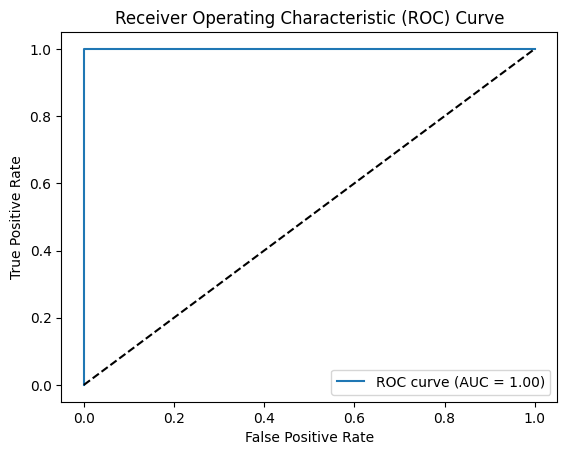

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the model's predicted probabilities for the positive class
y_pred_prob = model.predict(X_test)

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the Curve (AUC)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model on train and validation sets
train_predictions = model.predict(X_train)
train_r2_score = r2_score(y_train, train_predictions)

val_predictions = model.predict(X_test)
val_r2_score = r2_score(y_test, val_predictions)

print("Train R2 score:", train_r2_score)
print("Validation R2 score:", val_r2_score)


Epoch 1/10
223/223 [==============================] - 52s 220ms/step - loss: 0.0574 - accuracy: 0.9958 - val_loss: 0.0309 - val_accuracy: 0.9989
Epoch 2/10
223/223 [==============================] - 52s 232ms/step - loss: 0.0497 - accuracy: 0.9968 - val_loss: 0.2962 - val_accuracy: 0.9207
Epoch 3/10
223/223 [==============================] - 58s 260ms/step - loss: 0.0816 - accuracy: 0.9826 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 4/10
223/223 [==============================] - 57s 257ms/step - loss: 0.0387 - accuracy: 0.9980 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 5/10
223/223 [==============================] - 44s 197ms/step - loss: 0.0343 - accuracy: 0.9975 - val_loss: 0.0203 - val_accuracy: 0.9972
Epoch 6/10
223/223 [==============================] - 50s 223ms/step - loss: 0.1130 - accuracy: 0.9757 - val_loss: 0.5418 - val_accuracy: 0.8667
Epoch 7/10
223/223 [==============================] - 46s 208ms/step - loss: 0.1387 - accuracy: 0.9622 - val_loss: 0.0229 - val_ac

In [ ]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


In [ ]:
print("X_train shape:", X_train)

In [ ]:
print("y_train shape:", y_train)

In [ ]:
print("X_test shape:", X_test)

In [ ]:
print("y_test shape:", y_test)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)

56/56 [==============================] - 2s 35ms/step
Precision: [0.99302326 1.        ]
Recall: [1.         0.99350649]
F1-score: [0.99649942 0.99674267]
Support: [854 924]


In [ ]:
def preprocess_single_file(file_path, seq_length):
    df = pd.read_csv(file_path)
    df["label"] = 0  # Add a dummy label column
    data = df.values[:seq_length, :]  # Truncate to seq_length rows if needed
    #scaled_data = scaler.transform(data)
    #X = np.array([scaled_data[:, :-1]])  # Create a 3D array with just one sample
    X = np.array([data[:, :-1]])  # Create a 3D array with just one sample

    return X

def status(x):
    if x > 0.5:
        print("Unhealthy")
    else:
        print("Healthy")
# Example usage:

sample_file_path = "/content/drive/MyDrive/d_data_test/preprocessed_d_605916.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)
print(y_sample_pred[0])

# Print the result
status(y_sample_pred[0])

In [ ]:
# Example usage:

sample_file_path = "/content/drive/MyDrive/n_data_test/preprocessed_n_851866.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)

# Print the result
print(y_sample_pred[0])

status(y_sample_pred[0])


In [ ]:
print(model.summary())

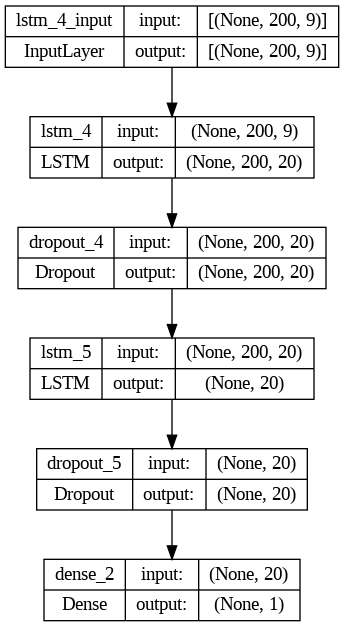

In [ ]:
from keras.utils import plot_model

# Assuming you have a trained LSTM model called 'model'
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Check class distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Class distribution in training set:", dict(zip(unique_train, counts_train)))
print("Class distribution in test set:", dict(zip(unique_test, counts_test)))

Class distribution in training set: {0.0: 3456, 1.0: 3652}
Class distribution in test set: {0.0: 854, 1.0: 924}


In [ ]:
from sklearn.metrics import classification_report

# Predict the test labels
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate and print the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Diseased'])
print(report)


56/56 [==============================] - 3s 51ms/step
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00       854
    Diseased       1.00      0.99      1.00       924

    accuracy                           1.00      1778
   macro avg       1.00      1.00      1.00      1778
weighted avg       1.00      1.00      1.00      1778



In [ ]:
from sklearn.model_selection import KFold
from keras.models import clone_model

def train_and_evaluate_model(X_train, y_train, X_val, y_val):
    # Create and compile a new instance of the model
    model = Sequential()
    model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(10))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    return accuracy

# Combine the train and test sets for cross-validation
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Define the number of folds for cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run cross-validation
cv_accuracies = []
for train_index, val_index in kfold.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    fold_accuracy = train_and_evaluate_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    cv_accuracies.append(fold_accuracy)

# Calculate and print the average accuracy across all folds
avg_accuracy = np.mean(cv_accuracies)
print(f"Average accuracy across {num_folds}-fold cross-validation: {avg_accuracy}")
print(f"5 accuracies: {cv_accuracies}")

Average accuracy across 5-fold cross-validation: 0.9148028135299683
5 accuracies: [0.976940393447876, 1.0, 0.626899242401123, 0.9966235160827637, 0.9735509157180786]


In [ ]:
# Data Augmentation [Windowing technique]
from keras.preprocessing.sequence import TimeseriesGenerator

# Define window size and stride
window_size = 10
stride = 1 

# Create TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(train_features_X, train_labels_y, length=window_size, stride=stride)

# Generate input sequences and corresponding labels for training data
X_train_sequences, y_train_labels = train_generator[0]

# Create TimeseriesGenerator for testing data
test_generator = TimeseriesGenerator(test_features_X, test_labels_y, length=window_size, stride=stride)

# Generate input sequences and corresponding labels for testing data
X_test_sequences, y_test_labels = test_generator[0]
